In [1]:
import os
import sys
from time import time
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

import numpy as np
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def cdist(X, Y):
    X2 = tf.reduce_sum(tf.square(X), 1)
    Y2 = tf.reduce_sum(tf.square(Y), 1)
    X2 = tf.reshape(X2, [-1, 1])
    Y2 = tf.reshape(Y2, [1, -1])
    # return pairwise euclidead difference matrix
    distances = tf.sqrt(tf.maximum(
        X2 + Y2 - 2 * tf.matmul(X, Y, False, True), 0.0))
    assert distances.shape == [X.shape[0], Y.shape[0]]
    return distances

In [3]:
def compute_T(K, u, v, n_iter, tol):
    """
    Parameters:
    -----------
        D: 2D array, [M, N]
        r: 1D array, [M, ]
        c: 1D array, [N, ]
        lambd: regularization parameter in Sinkhorn divergence
        p: power of the Wasserstein space
        n_iter: number of iterations for matrix balancing
        tol: tolerance for stopping matrix balancing iterations
    """
    K_tilde = 1. / u * K
    r = tf.zeros([int(u.shape[0]), 1], dtype=tf.float64)
    r_new = tf.ones([int(u.shape[0]), 1], dtype=tf.float64)

    def cond(r, r_new):
        r_enter = tf.reduce_any(tf.abs(r_new - r) > tol)
        return r_enter

    def body(r, r_new):
        r = r_new
        r_new = 1. / tf.matmul(K_tilde, v / tf.matmul(K, r, True, False))
        return [r, r_new]

    _, r = tf.while_loop(cond, body, [r, r_new], maximum_iterations=n_iter)
    c = v / tf.matmul(K, r, True, False)

    T_opt = tf.matmul(tf.diag(tf.reshape(r, (-1,))),
                      tf.matmul(K, tf.diag(tf.reshape(c, (-1,)))))

    return T_opt

In [4]:
def wasserstein_distance(n1, n2, embeddings, u, v, lambd, p, n_iter, tol):
    support_1 = embeddings[n1, :, :]
    support_2 = embeddings[n2, :, :]
    D = cdist(support_1, support_2)
    D_p = tf.pow(D, p)
    K = tf.exp(-D_p / lambd)
    T = compute_T(K, u, v, n_iter, tol)

    # distance = tf.trace(tf.matmul(D_p, T, False, True)) + lambd * \
    #     tf.trace(tf.matmul(T, tf.log(T) -
    #                        tf.ones(T.shape, dtype=tf.float64), False, True))
    distance = tf.trace(tf.matmul(D_p, T, False, True))
    return distance

def wasserstein_distances(pairs, embeddings, u, v, lambd, p, n_iter, tol):
    results = tf.map_fn(lambda x: wasserstein_distance(
        x[0], x[1], embeddings, u, v, lambd, p, n_iter, tol), pairs, dtype=tf.float64)
    return results

In [5]:
def euclidean_distance(n1, n2, embeddings):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    distance = tf.sqrt(tf.reduce_sum(tf.square(v1 - v2)))
    return distance

def euclidean_distances(pairs, embeddings):
    results = tf.map_fn(lambda x: euclidean_distance(x[0], x[1], embeddings), pairs, dtype=tf.float64)
    return results

In [6]:
def hyperbolic_distance(n1, n2, embeddings, eps):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    norm1 = tf.norm(v1)
    norm2 = tf.norm(v2)
    v1 = tf.cond(tf.greater_equal(norm1, 1), lambda: v1 / norm1 - eps, lambda: v1)
    v2 = tf.cond(tf.greater_equal(norm2, 1), lambda: v2 / norm2 - eps, lambda: v2)
    
    distance = tf.acosh(1 + 2 * tf.reduce_sum(tf.square(v1 - v2)) / ((1 - tf.reduce_sum(tf.square(v1))) * (1 - tf.reduce_sum(tf.square(v2)))))
    return distance

def hyperbolic_distances(pairs, embeddings, eps):
    results = tf.map_fn(lambda x: hyperbolic_distance(x[0], x[1], embeddings, eps), pairs, dtype=tf.float64)
    return results

In [7]:
def kl_distance(n1, n2, embeddings, eps):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    min1 = tf.reduce_min(v1)
    min2 = tf.reduce_min(v2)
    v1 = tf.cond(tf.less_equal(min1, 0), lambda: v1 - min1 + eps, lambda: v1)
    v2 = tf.cond(tf.less_equal(min2, 0), lambda: v2 - min2 + eps, lambda: v2)
    v1 = v1 / tf.norm(v1)
    v2 = v2 / tf.norm(v2)
    kl = (tf.reduce_sum(v1 * (tf.log(v1) - tf.log(v2))) + tf.reduce_sum(v2 * (tf.log(v2) - tf.log(v1)))) / 2
    return kl

def kl_distances(pairs, embeddings, eps):
    results = tf.map_fn(lambda x: kl_distance(x[0], x[1], embeddings, eps), pairs, dtype=tf.float64)
    return results

In [8]:
def train(node_pairs, obj_distances, embedding_type='Euc', n_epochs=500, learning_rate=0.01, u_v=None, nodes=128, embed_dim=20, ground_dim=2, lambd=1.0, p=1, mat_bal_iter=20, mat_bal_tol=1e-5, eps=1e-5):
    if u_v is None:
        u = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
        v = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
    
    n_nodes = int(obj_distances.shape[0])

    Node_Pairs = tf.placeholder(dtype=tf.int32, shape=[n_nodes, 2], name='Node_Pairs')
    Obj_Distances = tf.placeholder(dtype=tf.float64, shape=[n_nodes], name='Obj_Distances')
    Lambd = tf.placeholder(dtype=tf.float64, shape=(), name='Lambd')
    Learning_rate = tf.placeholder(dtype=tf.float64, shape=(), name='Learning_rate')

    if embedding_type == 'Wass':
        Embeddings = tf.Variable(tf.random.uniform(
        [nodes, embed_dim, ground_dim], dtype=tf.float64), name='Embeddings')
        Embed_Distances = wasserstein_distances(Node_Pairs, Embeddings, u, v, Lambd, p, mat_bal_iter, mat_bal_tol)
    elif embedding_type == 'Hyper':
        Embeddings = tf.Variable(0.002 * tf.random.uniform([nodes, embed_dim], dtype=tf.float64) - 0.001, name='Embeddings')
        Embed_Distances = hyperbolic_distances(Node_Pairs, Embeddings, eps)
    elif embedding_type == 'KL':
        Embeddings = tf.Variable(tf.random.uniform([nodes, embed_dim], dtype=tf.float64), name='Embeddings')
        Embed_Distances = kl_distances(Node_Pairs, Embeddings, eps)
    else:
        Embeddings = tf.Variable(tf.random.uniform([nodes, embed_dim], dtype=tf.float64), name='Embeddings')
        Embed_Distances = euclidean_distances(Node_Pairs, Embeddings)

    Loss = tf.reduce_mean(tf.abs(Embed_Distances - Obj_Distances) / Obj_Distances)
    Jac = tf.gradients(ys=Embed_Distances, xs=Embeddings)
    optimizer = tf.train.AdamOptimizer(Learning_rate).minimize(Loss)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        # Lists for storing the changing Cost and Accuracy in every Epoch
        loss_history = []
        time_history = []

        # best_loss = 1000
        # early_stopping_counter = 0
        start_time = time()
        for epoch in range(n_epochs):
           # Running the Optimizer
            _, embeddings, embed_distances, loss, jac = sess.run([optimizer, Embeddings, Embed_Distances, Loss, Jac], feed_dict={Node_Pairs: node_pairs, Obj_Distances: obj_distances, Lambd: lambd, Learning_rate: learning_rate})
            if np.isnan(loss):
                raise RuntimeError("Loss is NaN.")
            # Storing loss to the history
            loss_history.append(loss)
            # Storing consumed time
            time_history.append(time() - start_time)
            # Displaying result on current Epoch
            if epoch % 1 == 0:
                logging.info("Epoch: {}/{}, loss: {}".format(epoch+1, n_epochs, loss))
            # Early stopping check
            if epoch > 20 and np.mean(loss_history[-15:-5]) - loss_history[-1] < 1e-4:
                logging.info("Early Stopped: 10 consecutive epochs with loss improvement {}".format(loss_history[-2]-loss_history[-1]))
                break
            # if loss < best_loss:
            #     best_loss = loss
            #     early_stopping_counter = 0
            # else:
            #     early_stopping_counter += 1
            # if early_stopping_counter >= patience:
            #     break
    return embeddings, loss_history, time_history, embed_distances, jac

In [9]:
org_distances = np.loadtxt('./data/Sales_Transaction_Dataset.dist', delimiter=',')
logging.info("Load DTW distance data from local file")

file_name = 'Sales'
eps = 1e-8

embed_dims = [30]
n_epochs = 500
num_nodes = org_distances.shape[0]

node_pairs = np.array([[i, j] for i in range(num_nodes) for j in range(i+1, num_nodes)])
obj_distances = np.array([org_distances[i, j] for i in range(num_nodes) for j in range(i+1, num_nodes)])

logging.info("node pairs shape: {}, obj_distances shape: {}".format(
    node_pairs.shape, obj_distances.shape))

2019-05-01 01:00:31,690 - INFO - Load DTW distance data from local file
2019-05-01 01:00:32,181 - INFO - node pairs shape: (328455, 2), obj_distances shape: (328455,)


In [11]:
embed_dim = 30

In [12]:
obj_min = obj_distances.min()
obj_max = obj_distances.max()
obj_dist_norm = (obj_distances - obj_min) / (obj_max - obj_min)
obj_dist_norm += eps

In [13]:
from scipy.spatial.distance import squareform
import pandas as pd

In [14]:
obj_dist_matrix = squareform(obj_distances)

In [47]:
# Euclidean
logging.info("Running Euclidean embedding, embed dim={}".format(embed_dim))
embeddings_euc, loss_history_euc, time_history_euc, embed_distances_euc, jac_euc = train(
    node_pairs, obj_distances, embedding_type='Euc', embed_dim=embed_dim, 
    learning_rate=0.1, n_epochs=n_epochs, nodes=num_nodes)
# np.savez('./results/{}_{}_{}'.format(file_name, 'Euclidean', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

2019-04-28 19:25:28,916 - INFO - Running Euclidean embedding, embed dim=30
2019-04-28 19:26:31,421 - INFO - Epoch: 1/500, loss: 321.494426584417
2019-04-28 19:36:50,103 - INFO - Epoch: 11/500, loss: 66.39597250352524
2019-04-28 19:47:09,431 - INFO - Epoch: 21/500, loss: 25.860731877119388
2019-04-28 19:57:40,175 - INFO - Epoch: 31/500, loss: 16.187375122036343
2019-04-28 20:08:22,006 - INFO - Epoch: 41/500, loss: 9.390835719206324
2019-04-28 20:19:26,227 - INFO - Epoch: 51/500, loss: 6.846998174014989
2019-04-28 20:30:45,143 - INFO - Epoch: 61/500, loss: 5.346416044259939
2019-04-28 20:38:42,392 - INFO - Early Stopped: 10 consecutive epochs with loss improvement -1.1993371033788929


In [16]:
import seaborn as sns

Text(0.5, 1.0, 'Euclidean Embedding')

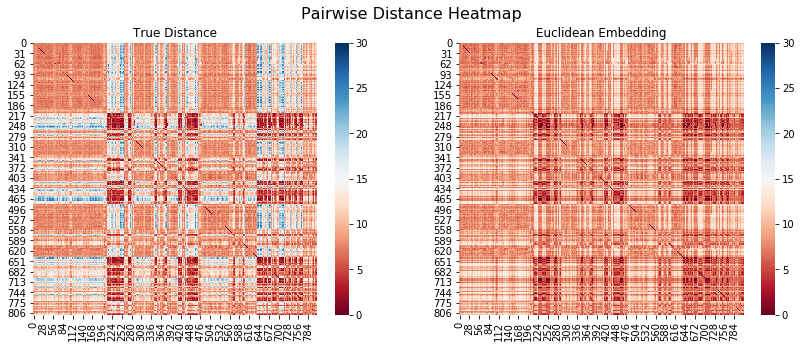

In [87]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(121)
# ax.set_title('True distance')
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))
ax.set_title("True Distance")

pred_distance = squareform(embed_distances)
ax = plt.subplot(122)
# ax.set_title(embed_types[(i+4)%5] + " embedding distance")
sns.heatmap(pred_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))
ax.set_title("Euclidean Embedding")

In [78]:
# Euclidean
logging.info("Running Euclidean embedding, embed dim={}".format(embed_dim))
embeddings_euc_norm, loss_history_euc_norm, time_history_euc_norm, embed_distances_euc_norm, jac_euc_norm = train(
    node_pairs, obj_dist_norm, embedding_type='Euc', embed_dim=embed_dim, 
    learning_rate=0.1, n_epochs=n_epochs, nodes=num_nodes)

2019-04-29 23:58:53,543 - INFO - Running Euclidean embedding, embed dim=30
2019-04-29 23:59:54,121 - INFO - Epoch: 1/500, loss: 318609.46137917513
2019-04-30 00:09:38,987 - INFO - Epoch: 11/500, loss: 67540.57764673093
2019-04-30 00:19:18,391 - INFO - Epoch: 21/500, loss: 24320.847845018652
2019-04-30 00:28:51,092 - INFO - Epoch: 31/500, loss: 15911.6174021115
2019-04-30 00:37:58,827 - INFO - Epoch: 41/500, loss: 8938.739922711713
2019-04-30 00:47:00,003 - INFO - Epoch: 51/500, loss: 6445.312439257416
2019-04-30 00:55:59,426 - INFO - Epoch: 61/500, loss: 5416.01390558359
2019-04-30 01:04:56,774 - INFO - Epoch: 71/500, loss: 5456.828263389952
2019-04-30 01:04:56,775 - INFO - Early Stopped: 10 consecutive epochs with loss improvement -749.442238897167


In [79]:
embed_distances_euc = embed_distances_euc_norm * (obj_max - obj_min) + obj_min

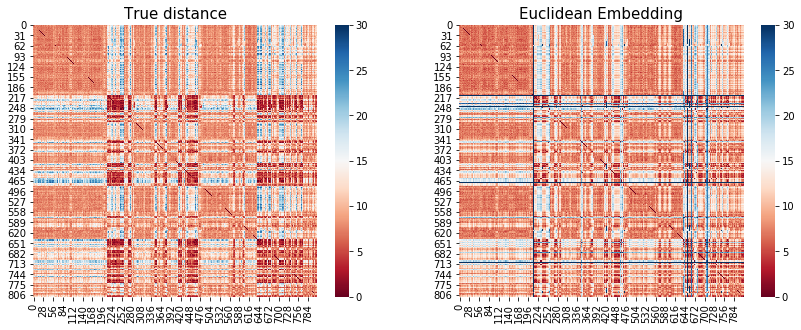

In [89]:
fig = plt.figure(figsize=(14, 5))
# fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(121)
ax.set_title('True distance', fontsize=15)
sns.heatmap(true_distance+eps, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

pred_distance = squareform(embed_distances_euc)
ax = plt.subplot(122)
# ax.set_title(embed_types[(i+4)%5] + " embedding distance")
ax.set_title('Euclidean Embedding', fontsize=15)
sns.heatmap(pred_distance, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

In [84]:
np.savez('./results/{}_{}_{}_norm'.format('Sales', 'Euclidean', embed_dim), 
    embeddings=embeddings_euc_norm, loss=loss_history_euc_norm, time=time_history_euc_norm, 
    embed_distances=embed_distances_euc)

## Hyperbolic

In [67]:
# Hyperbolic
logging.info("Running Hyperbolic embedding, embed dim={}".format(embed_dim))
while True:
    try:
        embeddings_hyper, loss_history_hyper, time_history_hyper, embed_distances_hyper, jac_hyper = train(
            node_pairs, obj_distances, embedding_type='Hyper', embed_dim=embed_dim, 
            learning_rate=0.005, n_epochs=n_epochs, nodes=num_nodes)
        break
    except RuntimeError:
        logging.warning("Got Loss NaN")
        continue
# np.savez('./results/{}_{}_{}'.format(file_name, 'Hyperbolic', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

2019-04-29 20:33:42,107 - INFO - Running Hyperbolic embedding, embed dim=30
2019-04-29 20:35:33,072 - INFO - Epoch: 1/500, loss: 2.2610800937457904
2019-04-29 20:56:18,382 - INFO - Epoch: 11/500, loss: 3.4791753509208716
2019-04-29 21:21:37,024 - INFO - Epoch: 21/500, loss: 2.3493007931430454
2019-04-29 21:45:43,279 - INFO - Epoch: 31/500, loss: 1.3375212625702568
2019-04-29 21:52:33,233 - WARNING - Got Loss NaN
2019-04-29 21:54:17,926 - INFO - Epoch: 1/500, loss: 2.2611878893417785


KeyboardInterrupt: 

In [72]:
# Hyperbolic
logging.info("Running Hyperbolic embedding, embed dim={}".format(embed_dim))
try_count = 0
while try_count < 5:
    try:
        embeddings_hyper_norm, loss_history_hyper_norm, time_history_hyper_norm, embed_distances_hyper_norm, jac_hyper_norm = train(
            node_pairs, obj_dist_norm, embedding_type='Hyper', embed_dim=embed_dim, 
            learning_rate=0.001, n_epochs=n_epochs, nodes=num_nodes)
        break
    except RuntimeError:
        logging.warning("Got Loss NaN")
        try_count += 1
# np.savez('./results/{}_{}_{}'.format(file_name, 'Hyperbolic', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

2019-04-29 22:01:51,238 - INFO - Running Hyperbolic embedding, embed dim=30
2019-04-29 22:03:43,179 - INFO - Epoch: 1/500, loss: 1272.8583095773195
2019-04-29 22:20:41,627 - INFO - Epoch: 11/500, loss: 463.2809172580434
2019-04-29 22:37:25,029 - INFO - Epoch: 21/500, loss: 240.3241666665017
2019-04-29 22:54:50,341 - INFO - Epoch: 31/500, loss: 134.76210970078495
2019-04-29 23:12:40,081 - INFO - Epoch: 41/500, loss: 101.41156656068246
2019-04-29 23:30:02,386 - INFO - Epoch: 51/500, loss: 94.3465180285359
2019-04-29 23:40:43,617 - INFO - Early Stopped: 10 consecutive epochs with loss improvement -9.447530503676731


In [74]:
embed_distances_hyper = embed_distances_hyper_norm * (obj_max - obj_min) + obj_min

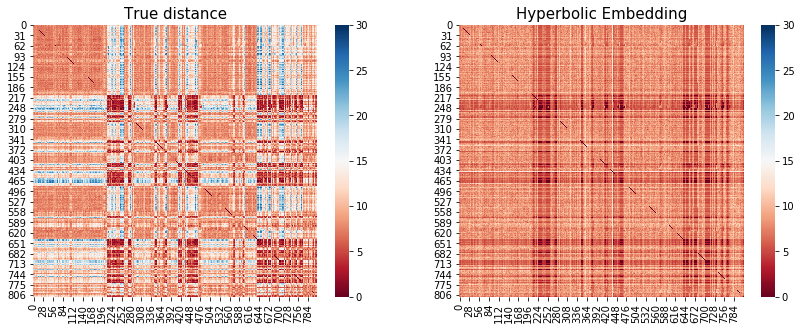

In [91]:
fig = plt.figure(figsize=(14, 5))
# fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(121)
ax.set_title('True distance', fontsize=15)
sns.heatmap(true_distance+eps, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

pred_distance = squareform(embed_distances_hyper)
ax = plt.subplot(122)
# ax.set_title(embed_types[(i+4)%5] + " embedding distance")
ax.set_title("Hyperbolic Embedding", fontsize=15)
sns.heatmap(pred_distance, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

In [76]:
np.savez('./results/{}_{}_{}_norm'.format('Sales', 'Hyper', embed_dim), 
    embeddings=embeddings_hyper_norm, loss=loss_history_hyper_norm, time=time_history_hyper_norm, 
    embed_distances=embed_distances_hyper)

# Wasserstein R2

In [ ]:
# Wass R2
logging.info("Running Wasserstein R2 embedding, embed dim={}".format(embed_dim))
embeddings_wass, loss_history_wass, time_history_wass, embed_distances_wass, jac_wass = train(
    node_pairs, obj_distances, embedding_type='Wass', embed_dim=embed_dim, 
    learning_rate=0.1, n_epochs=n_epochs, ground_dim=2, nodes=num_nodes)
# np.savez('./results/{}_{}_{}'.format(file_name, 'WassR2', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

In [ ]:
# Wass R2
logging.info("Running Wasserstein R2 embedding, embed dim={}".format(embed_dim))
embeddings_wass_norm, loss_history_wass_norm, time_history_wass_norm, embed_distances_wass_norm, jac_wass_norm = train(
    node_pairs, obj_dist_norm, embedding_type='Wass', embed_dim=embed_dim, 
    learning_rate=0.1, n_epochs=n_epochs, ground_dim=2, nodes=num_nodes)
# np.savez('./results/{}_{}_{}'.format(file_name, 'WassR2', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

2019-05-01 01:01:44,961 - INFO - Running Wasserstein R2 embedding, embed dim=30


In [ ]:
embed_distances_wass = embed_distances_wass_norm * (obj_max - obj_min) + obj_min

In [ ]:
fig = plt.figure(figsize=(14, 5))
# fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(121)
ax.set_title('True distance', fontsize=15)
sns.heatmap(true_distance+eps, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

pred_distance = squareform(embed_distances_wass)
ax = plt.subplot(122)
# ax.set_title(embed_types[(i+4)%5] + " embedding distance")
ax.set_title("Wasserstein R2 Embedding", fontsize=15)
sns.heatmap(pred_distance, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

In [ ]:
np.savez('./results/{}_{}_{}_norm'.format('Sales', 'WassR2', embed_dim), 
    embeddings=embeddings_wass_norm, loss=loss_history_wass_norm, time=time_history_wass_norm, 
    embed_distances=embed_distances_wass)

## KL

In [57]:
# KL
logging.info("Running KL embedding, embed dim={}".format(embed_dim))
embeddings_kl, loss_history_kl, time_history_kl, embed_distances_kl, jac_kl = train(
    node_pairs, obj_distances, embedding_type='KL', embed_dim=embed_dim, 
    learning_rate=0.01, n_epochs=n_epochs, nodes=num_nodes)
# np.savez('./results/{}_{}_{}'.format(file_name, 'KL', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

2019-04-28 21:24:17,245 - INFO - Running KL embedding, embed dim=30
2019-04-28 21:26:44,640 - INFO - Epoch: 1/500, loss: 316.9981196901143
2019-04-28 21:48:40,451 - INFO - Epoch: 11/500, loss: 138.47615781092406
2019-04-28 22:12:56,006 - INFO - Epoch: 21/500, loss: 64.40291671982699


KeyboardInterrupt: 

In [62]:
# KL
logging.info("Running KL embedding, embed dim={}".format(embed_dim))
embeddings_kl_norm, loss_history_kl_norm, time_history_kl_norm, embed_dist_kl_norm, jac_kl_norm = train(
    node_pairs, obj_dist_norm, embedding_type='KL', embed_dim=embed_dim, 
    learning_rate=0.01, n_epochs=n_epochs, nodes=num_nodes)

embed_distances_kl = embed_dist_kl_norm * (obj_max - obj_min) + obj_min

# np.savez('./results/{}_{}_{}'.format(file_name, 'KL', embed_dim), 
#     embeddings=embeddings, loss=loss_history, time=time_history, 
#     embed_distances=embed_distances)

2019-04-28 22:20:54,447 - INFO - Running KL embedding, embed dim=30
2019-04-28 22:23:15,461 - INFO - Epoch: 1/500, loss: 328806.7718893646
2019-04-28 22:47:08,829 - INFO - Epoch: 11/500, loss: 143209.39453098885
2019-04-28 23:10:28,984 - INFO - Epoch: 21/500, loss: 65729.84679117959
2019-04-28 23:36:45,420 - INFO - Epoch: 31/500, loss: 29461.82678291022
2019-04-29 00:02:31,631 - INFO - Epoch: 41/500, loss: 13212.196928216143
2019-04-29 00:23:10,843 - INFO - Epoch: 51/500, loss: 6163.387933448646
2019-04-29 00:42:11,895 - INFO - Epoch: 61/500, loss: 3103.580824842427
2019-04-29 01:01:10,917 - INFO - Epoch: 71/500, loss: 1698.0933048712582
2019-04-29 01:20:05,611 - INFO - Epoch: 81/500, loss: 974.3472738397987
2019-04-29 01:39:02,183 - INFO - Epoch: 91/500, loss: 573.888003767562
2019-04-29 01:57:55,365 - INFO - Epoch: 101/500, loss: 349.7075343046152
2019-04-29 02:16:50,878 - INFO - Epoch: 111/500, loss: 217.8047804449837
2019-04-29 02:35:49,027 - INFO - Epoch: 121/500, loss: 136.082477

In [63]:
embed_distances_kl = embed_dist_kl_norm * (obj_max - obj_min) + obj_min

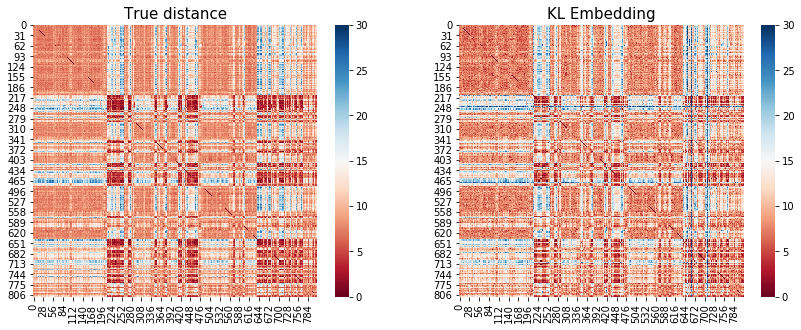

In [92]:
fig = plt.figure(figsize=(14, 5))
# fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(121)
ax.set_title('True distance', fontsize=15)
sns.heatmap(true_distance+eps, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

pred_distance = squareform(embed_distances_kl)
ax = plt.subplot(122)
# ax.set_title(embed_types[(i+4)%5] + " embedding distance")
ax.set_title("KL Embedding", fontsize=15)
sns.heatmap(pred_distance, cmap='RdBu', vmin=eps, vmax=int(round(true_distance.max()+eps)))

In [68]:
np.savez('./results/{}_{}_{}_norm'.format('Sales', 'KL', embed_dim), 
    embeddings=embeddings_kl_norm, loss=loss_history_kl_norm, time=time_history_kl_norm, 
    embed_distances=embed_distances_kl)